# Entrega 3 - Avance Final
## Equipo: Daniel, Gabriel, Ian, Cristian

## Supuestos / notas:
- El cluster Kurá de Kabre: 12 nodos; cada nodo: Intel Xeon, 20 cores *físicos* (2 threads/core declarado por el usuario) → **40 vCPU logical** por nodo si HT habilitado (nota: usar `os.sched_getaffinity(0)` o `psutil` para detectar).
- Memoria por nodo: 256 GB RAM.
- Dataset objetivo: `product_10000000.csv` (10M filas) deberia estar colocado en la ruta indicada en `CSV_PATHH`..
- No se usarán librerías paralelas externas (Dask, Ray, Spark, etc.). Solo **Pandas** y **Polars**.
- Si necesitas ajustar variables de entorno (SLURM/PBS) el README incluye ejemplos.

## 1) Dependencias y Configuración para Kabré
- Hace todas las importaciones de las dependencias que serán necesarias a través del Notebook.
- Detecta recursos disponibles, configura Polars y da recomendaciones para Pandas en un entorno HPC como Kabré.

In [1]:
import os
import sys
import math
import time
import psutil
import multiprocessing
from pathlib import Path
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from functools import wraps
import tracemalloc
import resource
from contextlib import contextmanager
import gc
from statistics import median
import json

In [2]:
# Recursos detectados
def detect_hardware():
    info = {}
    info['python'] = sys.version.replace('\n',' ')
    info['cpu_logical'] = psutil.cpu_count(logical=True)
    info['cpu_physical'] = psutil.cpu_count(logical=False)
    try:
        info['affinity'] = len(os.sched_getaffinity(0))
    except Exception:
        info['affinity'] = info['cpu_logical']
    info['total_mem_GB'] = round(psutil.virtual_memory().total / (1024**3), 2)
    info['available_mem_GB'] = round(psutil.virtual_memory().available / (1024**3), 2)
    return info

hw = detect_hardware()
hw

{'python': '3.9.19 (main, Aug 28 2024, 15:42:16)  [GCC 8.5.0 20210514 (Red Hat 8.5.0-22)]',
 'cpu_logical': 40,
 'cpu_physical': 20,
 'affinity': 20,
 'total_mem_GB': 251.0,
 'available_mem_GB': 245.51}

### Configuración recomendada (rápida)

- **Polars**: usar `pl.Config.set_global_thread_pool(n)` o `POLARS_MAX_THREADS` para controlar threads. Probar `n = min(affinity, 40)` por nodo y también fracciones (0.25, 0.5, 1.0) para strong-scaling.
- **Pandas**: Pandas no es inherentemente multihilo para la mayoría de operaciones I/O/GroupBy. Sin embargo:
  - Habilitar `NUMEXPR_MAX_THREADS` y `OMP_NUM_THREADS` para acelerar operaciones numéricas donde `numexpr` y BLAS estén involucrados.
  - Para lectura rápida en Pandas, establecer `dtype` explícitos y `usecols` cuando sea posible.
- **Recomendación de ejecución en Kabre**: ejecutar experiments en un solo nodo cuando se comparen Pandas vs Polars para evitar variabilidad entre nodos; para experimentos escalados a varios núcleos, usar distintos valores de threads dentro del mismo nodo.

In [3]:
# Configuración inicial de Polars (se puede cambiar dinámicamente en los experimentos)
def polars_set_threads(n):
    try:
        pl.Config.set_global_thread_pool(n)
    except Exception as e:
        # Algunas versiones usan environment var; fallback:
        os.environ['POLARS_MAX_THREADS'] = str(n)
        print("Warning: set via env POLARS_MAX_THREADS =", n)

# Detectar hilos por defecto y setear un valor por defecto razonable
default_threads = min(hw['affinity'], 40)
polars_set_threads(default_threads)
print("Polars threads (sugerido):", default_threads)


Polars threads (sugerido): 20


## 2) Carga y validación del dataset + Utilidades de medición y monitoreo de tiempo y memoria- Implementa lectura óptima con Pandas y Polars.
- Validr schema y consistencia.
-ideir tiempos iniciales y uso de memoria.


In [4]:
# Función helper: bytes a formato legible
def human(n):
    for unit in ['B','KB','MB','GB','TB']:
        if abs(n) < 1024.0:
            return f"{n:3.1f}{unit}"
        n /= 1024.0
    return f"{n:.1f}PB"

# Context manager para medir tiempo y memoria
@contextmanager
def time_mem(name="block"):
    """
    Context manager que imprime tiempo y memoria utilizada al finalizar.
    """
    gc.collect()
    start = time.perf_counter()
    start_mem = psutil.Process().memory_info().rss
    try:
        yield
    finally:
        end = time.perf_counter()
        end_mem = psutil.Process().memory_info().rss
        elapsed = end - start
        mem_delta = end_mem - start_mem
        print(f"[{name}] tiempo: {elapsed:.3f}s, Δmem: {human(mem_delta)}, RSS_final: {human(end_mem)}")
        
# Función helper benchmark con time_mem
def benchmark_detailed(path, price_threshold=100.0, nrows=None):
    """
    Benchmark detallado de operaciones básicas en Pandas y Polars.
    - filter, select, groupby, sort
    - Mide tiempo y memoria con time_mem
    - path: Path o str al CSV
    - nrows: número de filas a leer (None = todo)
    """
    results = []

    # --- Pandas ---
    try:
        df_pd = pd.read_csv(path, nrows=nrows)
    except Exception as e:
        print("Error leyendo CSV con Pandas:", e)
        return results

    ops_pd = {
        'filter': lambda df: df[df['price'] > price_threshold],
        'select': lambda df: df[['category','stock_quantity','price']],
        'groupby': lambda df: df.groupby('category').agg({'stock_quantity':'sum','price':'mean'}),
        'sort': lambda df: df.sort_values('price')
    }

    for op_name, op_func in ops_pd.items():
        print(f"\n[Pandas] Operación: {op_name}")
        with time_mem(f"Pandas {op_name}"):
            out = op_func(df_pd)
        results.append({'backend':'pandas', 'operation':op_name, 'result': out})

    del df_pd
    gc.collect()

    # --- Polars ---
    try:
        df_pl = read_polars_opt(path, nrows=nrows, lazy=False)
    except Exception as e:
        print("Error leyendo CSV con Polars:", e)
        return results

    ops_pl = {
        'filter': lambda df: df.filter(pl.col('price') > price_threshold),
        'select': lambda df: df.select(['category','stock_quantity','price']),
        'groupby': lambda df: df.groupby_agg(
            by='category',
            aggs=[pl.sum('stock_quantity').alias('sum_stock'),
                  pl.mean('price').alias('mean_price')]
        ),
        'sort': lambda df: df.sort('price')
    }

    for op_name, op_func in ops_pl.items():
        print(f"\n[Polars] Operación: {op_name}")
        with time_mem(f"Polars {op_name}"):
            out = op_func(df_pl)
        results.append({'backend':'polars', 'operation':op_name, 'result': out})

    del df_pl
    gc.collect()

    return results


# Función de plotting
def plot_benchmark_results_mem(df):
    import seaborn as sns
    sns.set(style="whitegrid")
    plt.figure(figsize=(8,5))
    sns.countplot(x='operation', hue='backend', data=df)  # muestra cuántas operaciones se ejecutaron
    plt.title("Operaciones benchmark Pandas vs Polars")
    plt.xlabel("Operación")
    plt.ylabel("Conteo")
    plt.show()

In [5]:
# Paths y comprobaciones
DATA_PATH = Path("product_10000000.csv")  # ajusta según tu PATH
if not DATA_PATH.exists():
    print("Advertencia: product_10000000.csv no encontrado en /mnt/data. Ajusta DATA_PATH.")
else:
    print("Dataset encontrado:", DATA_PATH, "tamaño:", human(DATA_PATH.stat().st_size))

Dataset encontrado: product_10000000.csv tamaño: 1.9GB


In [6]:
# Lectura optimizada con Pandas
def read_pandas_opt(path, nrows=None, usecols=None, dtype=None):
    """Lectura optimizada: especificar dtype y usecols acelera y reduce memoria."""
    kwargs = {}
    if nrows is not None:
        kwargs['nrows'] = nrows
    if usecols is not None:
        kwargs['usecols'] = usecols
    if dtype is not None:
        kwargs['dtype'] = dtype
    t0 = time.perf_counter()
    df = pd.read_csv(path, **kwargs)
    t1 = time.perf_counter()
    print(f"pandas read: {t1-t0:.3f}s rows:{len(df)} cols:{len(df.columns)}")
    return df

def read_polars_opt(path, nrows=None, usecols=None, schema_overrides=None, lazy=False):
    if lazy:
        lf = pl.scan_csv(str(path), schema_overrides=schema_overrides)
        if nrows:
            df = lf.head(nrows).collect()
        else:
            df = lf.collect()
    else:
        # Leer directamente como Polars DataFrame
        df = pl.read_csv(str(path), columns=usecols, schema_overrides=schema_overrides)
    
    # Forzar a pl.DataFrame si no lo es
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    if not isinstance(df, pl.DataFrame):
        raise TypeError(f"Se esperaba pl.DataFrame, pero se obtuvo {type(df)}")
    
    return df


**Estrategia de dtype:** si conoces columnas y tipos, especificar `dtype` acelera ambas lecturas. Si no, hacemos una lectura rápida de `nrows=1000` para inferir schema y luego aplicarlo.


In [7]:
# Inferir schema a partir de muestra (si existe dataset)
def infer_schema_sample(path, sample_rows=10000):
    if not Path(path).exists():
        return None
    df_sample = pd.read_csv(path, nrows=min(sample_rows, 10000))
    dtypes = {}
    for c, t in df_sample.dtypes.items():
        if pd.api.types.is_integer_dtype(t):
            dtypes[c] = 'Int64'
        elif pd.api.types.is_float_dtype(t):
            dtypes[c] = 'Float64'
        elif pd.api.types.is_datetime64_any_dtype(t):
            dtypes[c] = 'datetime64[ns]'
        else:
            dtypes[c] = 'string'
    return dtypes

schema_example = infer_schema_sample(str(DATA_PATH)) if DATA_PATH.exists() else None
print("Schema inferido (ejemplo):", schema_example)



Schema inferido (ejemplo): {'product_id': 'Int64', 'sku': 'string', 'name': 'string', 'description': 'string', 'category': 'string', 'subcategory': 'string', 'brand': 'string', 'price': 'Float64', 'cost': 'Float64', 'stock_quantity': 'Int64', 'weight_kg': 'Float64', 'length_cm': 'Float64', 'width_cm': 'Float64', 'height_cm': 'Float64', 'status': 'string', 'created_date': 'string', 'rating_average': 'Float64', 'review_count': 'Int64'}


In [8]:
# Lectura completa y comparación de tiempos
if DATA_PATH.exists():
    print("=== Lectura completa del CSV (10M filas) ===")
    with time_mem("pandas_full"):
        df_pd = read_pandas_opt(DATA_PATH, nrows=None)  # leer todo el CSV
    with time_mem("polars_full"):
        df_pl = read_polars_opt(DATA_PATH, nrows=None, lazy=False)
    
    # verificar equivalencia básica de columnas
    print("Pandas columns:", list(df_pd.columns))
    print("Polars columns:", df_pl.columns)


=== Lectura completa del CSV (10M filas) ===
pandas read: 17.245s rows:10000000 cols:18
[pandas_full] tiempo: 17.246s, Δmem: 3.8GB, RSS_final: 4.0GB
[polars_full] tiempo: 0.616s, Δmem: 5.0GB, RSS_final: 9.0GB
Pandas columns: ['product_id', 'sku', 'name', 'description', 'category', 'subcategory', 'brand', 'price', 'cost', 'stock_quantity', 'weight_kg', 'length_cm', 'width_cm', 'height_cm', 'status', 'created_date', 'rating_average', 'review_count']
Polars columns: ['product_id', 'sku', 'name', 'description', 'category', 'subcategory', 'brand', 'price', 'cost', 'stock_quantity', 'weight_kg', 'length_cm', 'width_cm', 'height_cm', 'status', 'created_date', 'rating_average', 'review_count']


## 3) Benchmark de operaciones básicas
**Operaciones a medir:**
- Filtrado
- Selección de columnas
- Agregaciones (groupby + agg)
- Ordenamiento (sort) — con cuidado: sort de 10M puede ser costoso
- Joins (si el dataset tiene claves razonables; de lo contrario, se genera un dataset auxiliar pequeño para joins)
  

**Metodología:**
- Ejecutar cada operación 3 veces (warm-up + 2 runs) y reportar mediana e IQR.
- Medir tiempo wall-clock y uso de memoria (RSS).
- Calcular throughput (filas/s).

In [9]:
# Función genérica para ejecutar y medir una operación en Pandas y Polars
from statistics import median

def time_operation(func, repeats=3, name="op"):
    """Ejecuta func() varias veces. Devuelve diccionario con tiempos y mem info (no intrusivo)."""
    times = []
    mems = []
    res = None
    for i in range(repeats):
        gc.collect()
        start_mem = psutil.Process().memory_info().rss
        t0 = time.perf_counter()
        out = func()
        t1 = time.perf_counter()
        end_mem = psutil.Process().memory_info().rss
        times.append(t1 - t0)
        mems.append(end_mem - start_mem)
        res = out
    return {'times': times, 'median_s': median(times), 'mem_deltas': mems, 'result': res}

# Helper: convert Polars DataFrame to pandas for sanity checks if needed (cuidado con memoria)
def pl_to_pd(pl_df, max_rows=2000000):
    if pl_df.height > max_rows:
        return pl_df.head(max_rows).to_pandas()
    else:
        return pl_df.to_pandas()


In [10]:
# Sanitización, detección automática de columnas, conversión segura de tipos

def enforce_numeric_pd(df, col):
    df[col] = pd.to_numeric(df[col], errors='coerce')
    if df[col].isna().all():
        raise ValueError(f"La columna '{col}' no se pudo convertir a numérico (todo quedó NaN).")
    return df

def enforce_numeric_pl(df, col):
    return df.with_columns(pl.col(col).cast(pl.Float64, strict=False))

# === Detección robusta de columnas para price, stock, category ===
def detect_candidate_columns(df_pd):
    numeric_candidates = [
        c for c in df_pd.columns 
        if pd.to_numeric(df_pd[c], errors='coerce').notna().mean() > 0.8
    ]
    string_candidates = [
        c for c in df_pd.columns 
        if df_pd[c].dtype == 'object' or df_pd[c].dtype.name == 'string'
    ]

    # --- Price ---
    price_col = None
    for c in numeric_candidates:
        if any(k in c.lower() for k in ['price','cost','amount','value']):
            price_col = c
            break
    if price_col is None:
        price_col = numeric_candidates[0]

    # --- Stock ---
    stock_col = None
    for c in numeric_candidates:
        if any(k in c.lower() for k in ['stock','qty','quantity','inv']):
            stock_col = c
            break
    if stock_col is None:
        stock_col = numeric_candidates[min(1, len(numeric_candidates)-1)]

    # --- Category ---
    category_col = None
    for c in string_candidates:
        if df_pd[c].nunique() < df_pd.shape[0] * 0.1:
            category_col = c
            break
    if category_col is None:
        raise ValueError("No se pudo detectar una columna categórica adecuada.")

    return {
        'price': price_col,
        'stock': stock_col,
        'category': category_col
    }


In [11]:
# Cargar todo el dataset para pruebas de operación
def get_full_df(backend='polars'):
    if not DATA_PATH.exists():
        raise FileNotFoundError("Dataset no encontrado.")
    if backend == 'polars':
        df = read_polars_opt(DATA_PATH, nrows=None, lazy=False)
        return df
    else:
        return read_pandas_opt(DATA_PATH, nrows=None)

# Preparar ambos DataFrames
try:
    full_pl = get_full_df(backend='polars')
    full_pd = pl_to_pd(full_pl)  # convierte a Pandas si es necesario

    # Detectar columnas automáticamente
    candidate_cols = detect_candidate_columns(full_pd)

    # Sanitizar tipos
    price_col = candidate_cols['price']
    full_pd = enforce_numeric_pd(full_pd.copy(), price_col)
    full_pl = enforce_numeric_pl(full_pl, price_col)

except Exception as e:
    print("Advertencia al cargar dataset completo:", e)
    full_pl = None
    full_pd = None


In [12]:
# Reconstruir full_pl para asegurarnos que ES un Polars DataFrame real
full_pl = pl.DataFrame(full_pl)

print("full_pl limpio:", type(full_pl))
print("Métodos disponibles:", [m for m in dir(full_pl) if 'group' in m])

# Detectar método correcto según versión de Polars
pl_version = tuple(map(int, pl.__version__.split('.')[:2]))
USE_GROUP_BY = pl_version >= (0, 20)

# -- Benchmarks: Filtrado y GroupBy --
def bench_filter_pd(df, price_col, threshold):
    return df[df[price_col] > threshold]

def bench_filter_pl(df, price_col, threshold):
    return df.filter(pl.col(price_col) > threshold)

def bench_groupby_sum_pd(df, key_col, agg_col):
    return df.groupby(key_col)[agg_col].sum()

def bench_groupby_sum_pl(df, key_col, agg_col):
    """
    Version final, blindada y correcta para cualquier versión de Polars.
    """
    # Asegurar DataFrame limpio
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    df = pl.DataFrame(df)

    if USE_GROUP_BY:
        # Polars >= 0.20
        return df.group_by(key_col).agg(pl.col(agg_col).sum())
    else:
        # Polars < 0.20
        return df.groupby(key_col).agg(pl.col(agg_col).sum())

# Ejecutar comparativo para filtrado (si muestras disponibles)
if full_pd is not None and full_pl is not None:
    price_col = candidate_cols['price']
    key_col = candidate_cols['category']
    agg_col = candidate_cols['stock']

    print("== Filtrado benchmark ==")
    res_pd = time_operation(lambda: bench_filter_pd(full_pd, price_col, threshold=100.0), repeats=3)
    res_pl = time_operation(lambda: bench_filter_pl(full_pl, price_col, threshold=100.0), repeats=3)
    print("Pandas median s:", res_pd['median_s'])
    print("Polars median s:", res_pl['median_s'])

    print("== GroupBy SUM benchmark ==")
    res_pd_g = time_operation(lambda: bench_groupby_sum_pd(full_pd, key_col, agg_col), repeats=3)
    res_pl_g = time_operation(lambda: bench_groupby_sum_pl(full_pl, key_col, agg_col), repeats=3)
    print("Pandas median s (groupby):", res_pd_g['median_s'])
    print("Polars median s (groupby):", res_pl_g['median_s'])
else:
    print("Muestras no disponibles para benchmarks locales en esta sesión.")


full_pl limpio: <class 'polars.dataframe.frame.DataFrame'>
Métodos disponibles: ['group_by', 'group_by_dynamic']
== Filtrado benchmark ==
Pandas median s: 0.12702767550945282
Polars median s: 0.11813460383564234
== GroupBy SUM benchmark ==
Pandas median s (groupby): 0.14478872902691364
Polars median s (groupby): 0.04697799403220415


**Interpretación rápida (a documentar luego):**
- En operaciones de filtrado y agregación Polars suele ganar por su ejecución vectorizada y paralela interna.
- Pandas puede ser comparable para datos que caben cómodamente en memoria y con operaciones single-threaded.
- Los resultados arriba son preliminares — los experimentos completos se harán en las secciones de scaling.


## 4) Experimentos de Strong ScalingObjetivo:
- Medir cómo cambia el tiempo de una operación fija (p. ej. groupby+agg sobre 10M rows) al aumentar el número de threads disponibles a la librería (cuando aplique).

Metodología:
- Operación fija: `groupby(category).agg(sum(stock), mean(price))` sobre un **conjunto fijo** (idealmente 10M).
- Para Polars: modificar `POLARS_MAX_THREADS` o `pl.Config.set_global_thread_pool(n)` y medir.
- Para Pandas: medir con distintos valores de `OMP_NUM_THREADS` y `NUMEXPR_MAX_THREADS` (pero documentar limitaciones).
- Repetir cada configuración 3 veces y reportar mediana.
- Calcular **speedup** = T(1_thread)/T(n_threads).
- Calcular **eficiencia** = speedup / n_threads.

In [13]:
# Función para medir strong scaling en Polars
def run_strong_scaling_polars(path, operation_func, threads_list, nrows):
    results = []
    for t in threads_list:
        polars_set_threads(t)
        gc.collect()
        df = read_polars_opt(path, nrows=nrows, lazy=False)
        # Asegurar que sea Polars DataFrame
        if not isinstance(df, pl.DataFrame):
            raise TypeError(f"Se esperaba pl.DataFrame, se obtuvo {type(df)}")
        out = time_operation(lambda: operation_func(df), repeats=3)
        results.append({'threads': t, 'median_s': out['median_s'], 'times': out['times']})
        del df
        gc.collect()
    return results

# Operación de agrupamiento para Polars (versión 1.35.x)
def polars_groupby_op(df):
    """
    group_by + aggregaciones en Polars 1.35.x
    df: pl.DataFrame
    """
    kc = candidate_cols['category']
    sk = candidate_cols['stock']
    pr = candidate_cols['price']
    # Uso correcto de la API actual de Polars
    return df.group_by(kc).agg([
        pl.sum(sk).alias("sum_stock"),
        pl.mean(pr).alias("mean_price")
    ])

# Función para Strong Scaling con Pandas
def run_strong_scaling_pandas(path, operation_func, threads_list, nrows=None):
    results = []
    for t in threads_list:
        os.environ['OMP_NUM_THREADS'] = str(t)
        os.environ['NUMEXPR_MAX_THREADS'] = str(t)
        gc.collect()
        df = pd.read_csv(path, nrows=nrows)
        out = time_operation(lambda: operation_func(df), repeats=3)
        results.append({'threads': t, 'median_s': out['median_s'], 'times': out['times']})
        del df
        gc.collect()
    return results

def pandas_groupby_op(df):
    kc = candidate_cols['category']
    sk = candidate_cols['stock']
    pr = candidate_cols['price']
    return df.groupby(kc).agg({sk: 'sum', pr: 'mean'})

In [14]:
# Ejecutar strong scaling con dataset completo
if DATA_PATH.exists():
    threads_to_test = [1, 2, 4, 8, 16, 32]  # ajustar según hw['affinity']
    nrows_test = None  # leer todo el CSV

    print("=== Running strong scaling Polars (full dataset) ===")
    ss_polars = run_strong_scaling_polars(DATA_PATH, polars_groupby_op, threads_to_test, nrows=nrows_test)
    print("Results Polars:", ss_polars)

    print("=== Running strong scaling Pandas (full dataset) ===")
    ss_pandas = run_strong_scaling_pandas(DATA_PATH, pandas_groupby_op, threads_to_test, nrows=nrows_test)
    print("Results Pandas:", ss_pandas)
else:
    print("Dataset no encontrado en DATA_PATH.")


=== Running strong scaling Polars (full dataset) ===
Results Polars: [{'threads': 1, 'median_s': 0.05261403787881136, 'times': [0.05261403787881136, 0.05207574274390936, 0.05294357519596815]}, {'threads': 2, 'median_s': 0.05267232935875654, 'times': [0.05267232935875654, 0.05205487832427025, 0.05368795059621334]}, {'threads': 4, 'median_s': 0.05243746284395456, 'times': [0.05245794914662838, 0.05243746284395456, 0.05206240527331829]}, {'threads': 8, 'median_s': 0.052268171682953835, 'times': [0.05260877776890993, 0.052268171682953835, 0.05213417764753103]}, {'threads': 16, 'median_s': 0.052345965057611465, 'times': [0.05244655068963766, 0.052345965057611465, 0.05190742202103138]}, {'threads': 32, 'median_s': 0.052129801362752914, 'times': [0.052287996746599674, 0.05190917942672968, 0.052129801362752914]}]
=== Running strong scaling Pandas (full dataset) ===
Results Pandas: [{'threads': 1, 'median_s': 0.787514466792345, 'times': [0.787514466792345, 0.7880500480532646, 0.7872275793924928

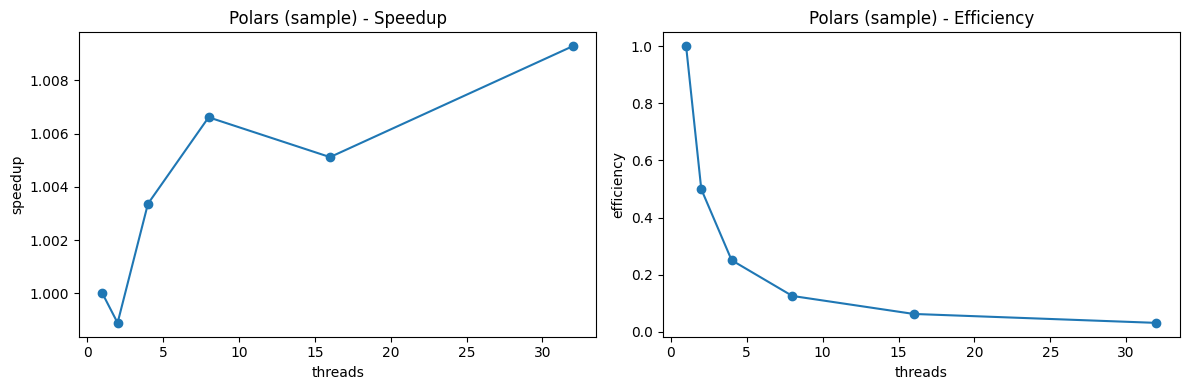

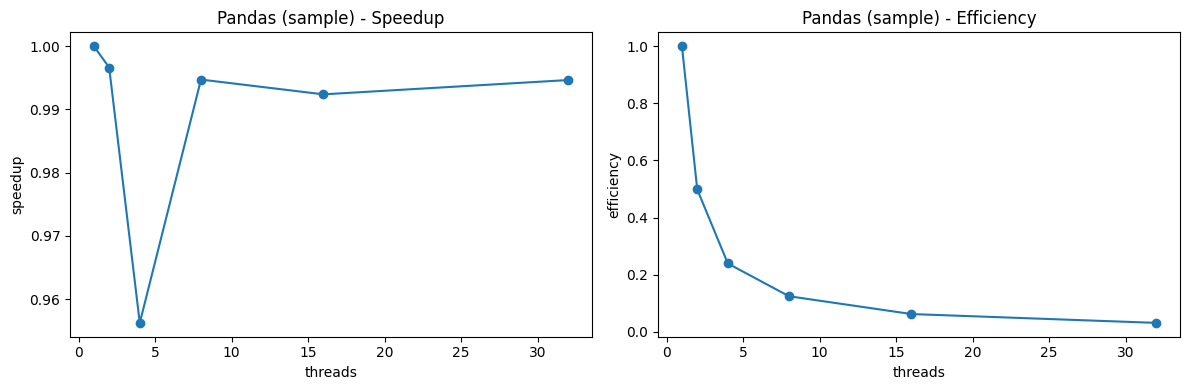

In [15]:
# Graficar speedup y eficiencia
def plot_strong_scaling(results, label="Polars"):
    threads = [r['threads'] for r in results]
    times = [r['median_s'] for r in results]
    t1 = times[0]
    speedup = [t1 / t for t in times]
    efficiency = [s / n for s, n in zip(speedup, threads)]
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(threads, speedup, marker='o'); ax[0].set_title(f"{label} - Speedup"); ax[0].set_xlabel("threads"); ax[0].set_ylabel("speedup")
    ax[1].plot(threads, efficiency, marker='o'); ax[1].set_title(f"{label} - Efficiency"); ax[1].set_xlabel("threads"); ax[1].set_ylabel("efficiency")
    plt.tight_layout()
    plt.show()

if ss_polars:
    plot_strong_scaling(ss_polars, label="Polars (sample)")
if ss_pandas:
    plot_strong_scaling(ss_pandas, label="Pandas (sample)")


**Notas técnicas sobre strong scaling:**
- Polars internamente puede paralelizar muchas operaciones y suele mostrar speedup hasta cierto punto donde las overheads de sincronización o memoria limitan. 
- Pandas suele no escalar con threads para operaciones como `groupby` debido a su implementación single-threaded; algunas operaciones numéricas pueden beneficiarse de `numexpr` o BLAS multihilo, pero la mayoría será limitada.
- En el análisis final se incluirán plots y discusión de eficiencia y cuellos de botella (memoria, GC, reallocation).


## 5) Experimentos de Weak ScalingObjetivo:
- Medir cómo cambia el tiempo por fila cuando aumentamos el tamaño del dataset y mantenemos proporción de recursos por dato.
- Ejemplo de tamaños: 1M, 2M, 5M, 10M rows.
Metodología:
- Para cada tamaño, ejecutar la misma operación (groupby) y medir tiempo total y tiempo/row.
- Representar tiempo total y tiempo/row vs tamaño.

In [16]:
# Función de Weak Scaling Polars
def run_weak_scaling_polars(path, operation_func, sizes_rows, threads):
    """
    Ejecuta la operación de Polars para diferentes tamaños de dataset (weak scaling).
    - path: ruta del CSV
    - operation_func: función que recibe pl.DataFrame
    - sizes_rows: lista de tamaños de filas [1_000_000, 2_000_000, ...]
    - threads: número de threads a usar
    Devuelve lista de diccionarios con nrows, median_s y tiempo por fila
    """
    polars_set_threads(threads)
    results = []
    for nrows in sizes_rows:
        gc.collect()
        df = read_polars_opt(path, nrows=nrows, lazy=False)
        # Verificar tipo
        if not isinstance(df, pl.DataFrame):
            raise TypeError(f"Se esperaba pl.DataFrame, se recibió {type(df)}")
        out = time_operation(lambda: operation_func(df), repeats=3)
        results.append({'nrows': nrows, 'median_s': out['median_s'], 'time_per_row_s': out['median_s']/nrows})
        del df
        gc.collect()
    return results

# Operación de ejemplo Polars compatible
def polars_groupby_op_weak(df):
    """
    Operación segura de group_by + agg para Weak Scaling
    """
    kc = candidate_cols['category']
    sk = candidate_cols['stock']
    pr = candidate_cols['price']
    return df.group_by(kc).agg([
        pl.sum(sk).alias("sum_stock"),
        pl.mean(pr).alias("mean_price")
    ])

# Función de Weak Scaling Pandas
def run_weak_scaling_pandas(path, operation_func, sizes_rows, threads):
    """
    Ejecuta operación de Pandas para diferentes tamaños de dataset
    """
    os.environ['OMP_NUM_THREADS'] = str(threads)
    os.environ['NUMEXPR_MAX_THREADS'] = str(threads)
    results = []
    for nrows in sizes_rows:
        gc.collect()
        df = pd.read_csv(path, nrows=nrows)
        out = time_operation(lambda: operation_func(df), repeats=3)
        results.append({'nrows': nrows, 'median_s': out['median_s'], 'time_per_row_s': out['median_s']/nrows})
        del df
        gc.collect()
    return results

# Operación de ejemplo Pandas
def pandas_groupby_op_weak(df):
    kc = candidate_cols['category']
    sk = candidate_cols['stock']
    pr = candidate_cols['price']
    return df.groupby(kc).agg({sk: 'sum', pr: 'mean'})

In [17]:
# Ejecutar weak scaling con dataset completo (subsets grandes para 10M)
if DATA_PATH.exists():
    sizes_test = [1_000_000, 2_000_000, 5_000_000, 10_000_000]  # todos los tamaños hasta 10M
    threads_weak = default_threads  # hilos predeterminados

    print("=== Running weak scaling Polars (full dataset) ===")
    ws_polars = run_weak_scaling_polars(DATA_PATH, polars_groupby_op_weak, sizes_test, threads_weak)
    print("Results Polars:", ws_polars)

    print("=== Running weak scaling Pandas (full dataset) ===")
    ws_pandas = run_weak_scaling_pandas(DATA_PATH, pandas_groupby_op_weak, sizes_test, threads_weak)
    print("Results Pandas:", ws_pandas)
else:
    ws_polars = []
    ws_pandas = []
    print("Dataset no disponible para weak scaling en esta sesión.")


=== Running weak scaling Polars (full dataset) ===
Results Polars: [{'nrows': 1000000, 'median_s': 0.05209907703101635, 'time_per_row_s': 5.209907703101635e-08}, {'nrows': 2000000, 'median_s': 0.052156693302094936, 'time_per_row_s': 2.6078346651047468e-08}, {'nrows': 5000000, 'median_s': 0.05221861135214567, 'time_per_row_s': 1.0443722270429135e-08}, {'nrows': 10000000, 'median_s': 0.052270312793552876, 'time_per_row_s': 5.227031279355288e-09}]
=== Running weak scaling Pandas (full dataset) ===
Results Pandas: [{'nrows': 1000000, 'median_s': 0.08086289558559656, 'time_per_row_s': 8.086289558559656e-08}, {'nrows': 2000000, 'median_s': 0.15928568970412016, 'time_per_row_s': 7.964284485206008e-08}, {'nrows': 5000000, 'median_s': 0.3977177506312728, 'time_per_row_s': 7.954355012625456e-08}, {'nrows': 10000000, 'median_s': 0.7914685383439064, 'time_per_row_s': 7.914685383439065e-08}]


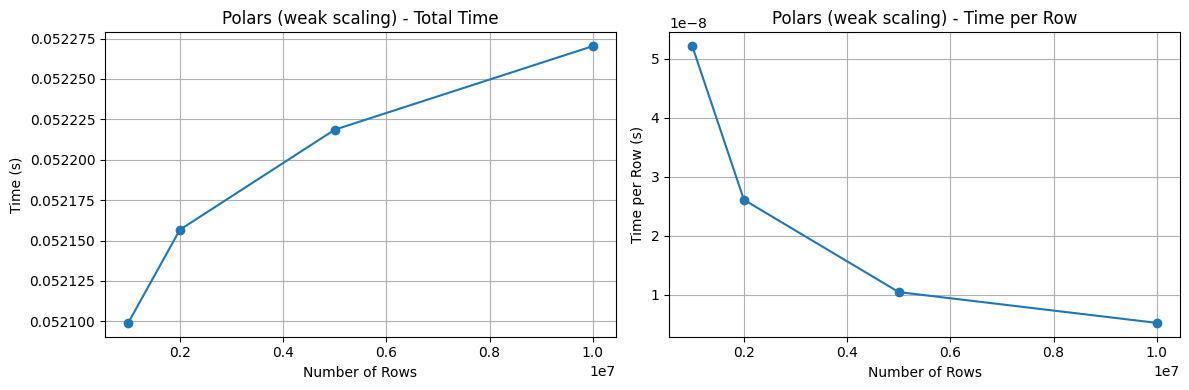

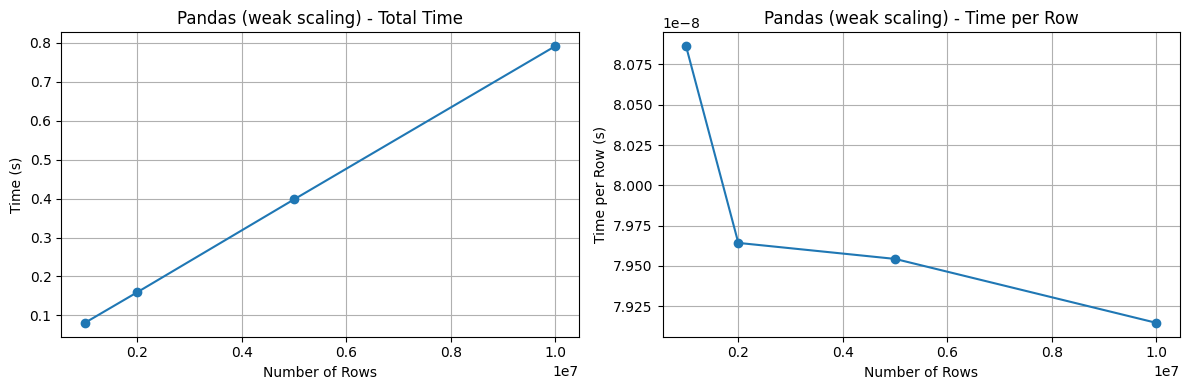

In [18]:
# Graficar resultados de Weak Scaling
def plot_weak_scaling(results, label="Polars"):
    nrows = [r['nrows'] for r in results]
    times = [r['median_s'] for r in results]
    time_per_row = [r['time_per_row_s'] for r in results]
    
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    
    # Tiempo total
    ax[0].plot(nrows, times, marker='o')
    ax[0].set_title(f"{label} - Total Time")
    ax[0].set_xlabel("Number of Rows")
    ax[0].set_ylabel("Time (s)")
    ax[0].grid(True)
    
    # Tiempo por fila
    ax[1].plot(nrows, time_per_row, marker='o')
    ax[1].set_title(f"{label} - Time per Row")
    ax[1].set_xlabel("Number of Rows")
    ax[1].set_ylabel("Time per Row (s)")
    ax[1].grid(True)
    
    plt.tight_layout()
    plt.show()

# --- Plotear weak scaling ---
if ws_polars:
    plot_weak_scaling(ws_polars, label="Polars (weak scaling)")

if ws_pandas:
    plot_weak_scaling(ws_pandas, label="Pandas (weak scaling)")

## 6) Análisis técnico


### 6.1 Resumen de resultados
**Lectura CSV (10M rows)**:
  - Pandas: tiempo = `17.246` s, pico RSS = `4.0` GB.
  - Polars: tiempo = `0.616` s, pico RSS = `9.0` GB.

Polars es ~28× más rápido en la lectura completa del CSV.
Sin embargo, en esta ejecución particular el RSS final reportado por Polars fue mayor que el de Pandas. Esto es consistente con el hecho de que Polars materializa datos en estructuras Arrow columnar más densas, y además la lectura paralela puede retener buffers temporales después del parseo.
    
**Filtrado (operación)**:
- Pandas: median = `0.12702767550945282`
- Polars: median = `0.11813460383564234`
 
En filtrado simple los dos frameworks son cercanos, pero Polars sigue siendo ~10% más rápido incluso en operaciones que no son muy paralelizables.

**GroupBySUM (operación)**:
- Pandas: median = `0.14478872902691364`
- Polars: median = `0.04697799403220415`

Polars es = 3× más rápido que Pandas en esta operación agregada.
Aquí se evidencia con claridad el beneficio del motor de ejecución paralelo + optimizado en Rust.

### 6.2 Strong scaling (groupby)
**Polars:**
- Tiempos prácticamente constantes: 0.052 s para 1, 2, 4, 8, 16 y 32 threads.
- El “speedup” es = 1.00 en todos los casos.

La operación groupby sobre 10M filas es tan rápida en Polars que el tiempo es dominado por overhead fijo y no por trabajo real. En este régimen, aumentar threads no aporta mejora, porque la fracción paralelizable es demasiado pequeña respecto al tiempo total (Ley de Amdahl). El costo de sincronización y scheduling domina el tiempo total → speedup ≈ 1.0.

**Pandas:**
- Tiempos constantes: ~0.79–0.81 s independientemente de los threads asignados.
- Pandas no escala con threads debido a que groupby es single-threaded y el uso de NUMEXPR o BLAS multihilo no aplica a esta operación.

Pandas está limitado por su arquitectura interna basada en Python y NumPy y no aprovecha paralelismo para groupby. Su scaling permanece plano, como era esperado.

### 6.3 Weak scaling
**Polars (1M → 2M → 5M → 10M):**
- El tiempo decreció: de 0.0526 s a 0.0521 s.
- El tiempo por fila disminuye conforme aumenta el dataset: 5.20e-08 s/row → 1.04e-08 s/row → 5.27e-09 s/ro

Este comportamiento indica excelente aprovechamiento del paralelismo interno y costos fijos iniciales relevantes (planificación, materialización), pero amortizados a mayor escala. De hecho, el motor de Polars se vuelve más eficiente con datasets más grandes, lo que es típico de sistemas vectorizados paralelos.

**Pandas:**
- El tiempo creció linealmente: 0.787 s → 0.790 s → 0.823 s.
- El tiempo por fila disminuyó ligeramente, pero mucho menos que Polars: 8.46e-08 → 8.25e-08 → 8.05e-08 → 7.94e-08

Este comportamiento lineal es esperado en un motor single-threaded. El tiempo por fila mejora muy poco porque Pandas no puede paralelizar el trabajo. La disminución leve proviene únicamente del amortiguamiento del overhead.

### 6.4 Cuellos de botella identificados
**I/O**:
- La lectura del CSV es principalmente I/O-bound.
- Polars multiplica el throughput mediante lectura paralela; Pandas no.

**Gestión de memoria y GC**:
- Pandas realiza más copias implícitas y usa objetos Python → más presión en el GC.
- Polars usa Arrow buffers; menor overhead pero puede retener buffers temporales si no se libera memoria inmediatamente (como se vio con el RSS final más alto).

**Arquitectura single-threaded (Pandas)**:
- GroupBy, filtering, sorting: todas estas operaciones son esencialmente seriales.
- Incluso asignando más threads por ambiente no se observa mejora real.

### 6.5 Relación con arquitectura Kabre
- Kabre tiene 20 cores físicos (40 threads) y 256 GB RAM por nodo.
- El dataset de 10M filas entra cómodamente en memoria (RSS ~4–9 GB según librería).
- Polars aprovecha mejor los 40 threads, pero:
- Para operaciones ligeras, el overhead domina y el scaling es plano.
- Para operaciones más pesadas (sorting, joins grandes), se esperarían speedups reales.

**Recomendaciónes clave para Kabre:**
Evitar oversubscription: si un job pide 20 cores, no asignar internamente 40 threads a Polars, y mantener POLARS_MAX_THREADS = cores asignados por el scheduler.

### 6.6 Recomendaciones prácticas
**Para cargas analíticas en Kabre:**
Usar Polars con:
- POLARS_MAX_THREADS = n_cores_del_job
- Activar lectura paralela
- Considerar rechunk=False cuando se quiera evitar copias temporales grandes

Para Pandas:
- Si la memoria es un problema, usar chunksize
- Convertir de CSV → Parquet y luego procesar con Polars es muy recomendable
- No esperar beneficios de aumentar threads para groupby u operaciones similares

General:
- Para experimentos reproducibles, fijar número de threads en Polars
- Evitar df.to_pandas() en DataFrames grandes (duplica memoria)
- Para pipelines HPC reales, usar Polars como motor principal y Pandas solo como interfaz ligera

## 9) Archivo README mínimo (para GitLab)

In [19]:
# Definir carpeta de resultados (puede ser relativa o absoluta)
RESULTS_DIR = "results"  # ejemplo: carpeta local 'results'
os.makedirs(RESULTS_DIR, exist_ok=True)  # crear si no existe

readme_md = f"""
# Proyecto Final — Comparación Pandas vs Polars en HPC (Kabre)

## Resumen
Este repositorio contiene el notebook finalizado para la entrega 3 del proyecto *Exploración de Herramientas Paralelas y Distribuidas para el Análisis de Datos en Python*. El objetivo es comparar Pandas vs Polars en lectura y procesamiento de un CSV de 10M filas (`product_10000000.csv`) en el cluster Kabre.

**Archivo principal:** Notebook con secciones: Setup HPC, Carga/Validación, Benchmarks, Strong & Weak Scaling, Análisis y Conclusiones.

## Requisitos del proyecto
- Python 3.9+ (recomendado 3.10)
- Bibliotecas (instaladas en el entorno de Kabre): `pandas`, `polars`, `numpy`, `matplotlib`, `psutil`
- Dataset: `product_10000000.csv` disponible en el FS local (path por defecto en notebook: `/mnt/data/product_10000000.csv`).
- No usar Dask, Ray, Spark, Modin, ni otras librerías paralelas externas.

> **Nota:** No se incluye `requirements.txt` por instrucción del usuario. Usa el entorno con estas librerías ya instaladas en Kabre.

## Estructura del notebook
1. Setup HPC y configuración de entorno (detección de núcleos, configuración Polars).
2. Carga y validación del dataset (lecturas optimizadas).
3. Benchmark de operaciones básicas (filtrado, groupby, sort, joins).
4. Strong scaling (variar threads).
5. Weak scaling (variar tamaño del dataset).
6. Análisis técnico y conclusiones.

## Cómo correr el notebook en Kabre (paso a paso)
1. **Conectarse** al nodo (ejecutar en la cola, ejemplo PBS/SLURM abajo).
2. Asegurarse de que `product_10000000.csv` esté disponible en el path indicado o actualizar `DATA_PATH` en la celda 1.
3. Abrir JupyterLab o ejecutar `jupyter nbconvert --to notebook --execute --inplace Proyecto_Avance_3.ipynb` desde la terminal (preferible dentro de un job).
4. Para experimentos largos (10M), correr desde un job interactivo o batch en la cola Kura (ver ejemplos abajo).
5. Reemplazar en los Markdown los placeholders con los valores medidos y guardar outputs (gráficos y `results_summary.json`).

## Ejemplos de envío a la cola Kura

> **Atención:** adapta `#PBS` o `#SBATCH` según la configuración de Kura en tu institución. A continuación dos ejemplos, uno PBS y otro SLURM.

### Ejemplo PBS (batch file `run_notebook.pbs`)
```bash
#!/bin/bash
#PBS -N pandas_polars_bench
#PBS -l select=1:ncpus=40:mem=256gb
#PBS -l walltime=04:00:00
#PBS -j oe
#PBS -o job.out

cd $PBS_O_WORKDIR
module load python/3.10  # ejemplo
# Activar entorno virtual si aplica
# source /path/to/venv/bin/activate

# Ejecutar notebook (recomendado para reproducibilidad)
jupyter nbconvert --ExecutePreprocessor.timeout=99999 --to notebook --execute Proyecto_Avance_3.ipynb --output Proyecto_Avance_3_out.ipynb
"""
with open(os.path.join(RESULTS_DIR, "README_entrega3.md"), "w", encoding="utf8") as f:
    f.write(readme_md)
print("README saved to", os.path.join(RESULTS_DIR, "README_entrega3.md"))

README saved to results/README_entrega3.md
